In [2]:
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
cnx = create_engine('postgresql://ubuntu@54.213.55.1:5432/ponv')

In [ ]:
# Query to get surgery procedures translated and a count
query = '''
select pt.procedure_en, count(1)
from ponvfull pf
INNER JOIN proc_trans pt ON pt.surgical_procedure = pf.surgical_procedure 
group by pt.surgical_procedure, pf.surgical_procedure 
order by count(1) DESC
'''

proc_table_en = pd.read_sql_query(query, cnx)
proc_table_en.head(10)

In [ ]:
# Script to create statements to dummify surgeries
for proc in proc_table_en.iloc[:,0]:
    def_string = 'count(CASE WHEN procedure_en = '
    def_string2 = 'THEN 1 END) AS '
    print(def_string+"'"+proc+"'"+def_string2+proc.replace(' ','_')+',')

In [ ]:
proc_dummy_query = '''
SELECT  trtbl.patientid, trtbl.procedure_en,
count(CASE WHEN procedure_en = 'Gastrointestinal'THEN 1 END) AS Gastrointestinal,
	count(CASE WHEN procedure_en = 'Mastectomy'THEN 1 END) AS Mastectomy,
	count(CASE WHEN procedure_en = 'Thoracic'THEN 1 END) AS Thoracic,
	count(CASE WHEN procedure_en = 'Nephrectomy'THEN 1 END) AS Nephrectomy,
	count(CASE WHEN procedure_en = 'Hysterectomy'THEN 1 END) AS Hysterectomy,
	count(CASE WHEN procedure_en = 'Exploratory Laparotomy'THEN 1 END) AS Exploratory_Laparotomy,
	count(CASE WHEN procedure_en = 'Other'THEN 1 END) AS Other,
	count(CASE WHEN procedure_en = 'Spine Surgery'THEN 1 END) AS Spine_Surgery,
	count(CASE WHEN procedure_en = 'Cystectomy'THEN 1 END) AS Cystectomy,
	count(CASE WHEN procedure_en = 'Prostatectomy'THEN 1 END) AS Prostatectomy,
	count(CASE WHEN procedure_en = 'Hepatectomy'THEN 1 END) AS Hepatectomy,
	count(CASE WHEN procedure_en = 'Plastic'THEN 1 END) AS Plastic,
	count(CASE WHEN procedure_en = 'Cytoreduction'THEN 1 END) AS Cytoreduction,
	count(CASE WHEN procedure_en = 'Anexectomy/Ovariectomy/'THEN 1 END) AS Anexectomy_Ovariectomy,
	count(CASE WHEN procedure_en = 'Head/Neck'THEN 1 END) AS Head_Neck,
	count(CASE WHEN procedure_en = 'Orthopedic'THEN 1 END) AS Orthopedic,
	count(CASE WHEN procedure_en = 'Hysterectomy VLP'THEN 1 END) AS Hysterectomy_VLP,
	count(CASE WHEN procedure_en = 'Extensive Lymphadenectomy'THEN 1 END) AS Extensive_Lymphadenectomy,
	count(CASE WHEN procedure_en = 'Esophagectomy'THEN 1 END) AS Esophagectomy,
	count(CASE WHEN procedure_en = 'Breast Lumpectomy'THEN 1 END) AS Breast_Lumpectomy,
	count(CASE WHEN procedure_en = 'Pancreatectomy'THEN 1 END) AS Pancreatectomy,
	count(CASE WHEN procedure_en = 'Hip Arthoplasty'THEN 1 END) AS Hip_Arthoplasty,
	count(CASE WHEN procedure_en = 'Soft Tissue Resection'THEN 1 END) AS Soft_Tissue_Resection,
	count(CASE WHEN procedure_en = 'Limb Amputation'THEN 1 END) AS Limb_Amputation,
	count(CASE WHEN procedure_en = 'Gallbladder'THEN 1 END) AS Gallbladder
FROM 
(SELECT patientid, pt.surgical_procedure, pt.procedure_en
FROM ponvfull pf
INNER JOIN proc_trans pt ON pf.surgical_procedure = pt.surgical_procedure) AS trtbl
GROUP BY trtbl.patientid, trtbl.procedure_en;
'''

In [ ]:
# Select primary data set with populated PONV data
sample_select_query = '''
SELECT *
FROM analysis_set
''' 
raw_df = pd.read_sql_query(sample_select_query, cnx)

# Start analysis here after pulling in raw data from SQL

In [ ]:
#raw_df.to_pickle('../pkl_files/raw_df.pkl')

In [40]:
raw_df = pd.read_pickle('../pkl_files/raw_df.pkl')

In [ ]:
'''(no_dropnull['anesthesia_technique'] == 4)&
no_dropnull = raw_df[raw_df['neuraxial_opioid'].notnull()]
no_dropnull['neuraxial_opioid'].map({True:1, False:0})
no_dropnull[(no_dropnull['neuraxial_opioid'] == ' ')].iloc[:,15:17]
no_dropnull[(no_dropnull['neuraxial_opioid'] == None)]
''''''

## Drop reasons:
1) nausea_24h: somewhat a symptom of outcome and therefore too correlated with ponv\
2) sex: gender_code replaces\
3) chemotherapy_emetogenicity: duplicative given other features and too many NaN\
4) neuraxial_opioid: unable to identify NaN values; will readdress if needed\
5) Ever smoked is duplicate column

In [43]:
raw_df['when_stopped_smoking'].value_counts()

1.0    1015
2.0     579
3.0     101
5.0      85
4.0      32
Name: when_stopped_smoking, dtype: int64

In [4]:
raw_df = raw_df[raw_df['fentanil_mcg'] < 3000]

In [5]:
# dropping duplicate rows or features that cauase leakage
analysis_df = raw_df.drop(['nausea_24h', 'ever_smoked', 'sex', 'chemotherapy_emetogenicity', 'neuraxial_opioid', 
                           'nausea24h_intensity', 'vomiting24h_count'], axis=1).copy()

In [6]:
#set nan ketamine dose to median
analysis_df.loc[308,'ketamine_dose'] = analysis_df[analysis_df['ketamine_dose'] > 0]['ketamine_dose'].median()

In [7]:
analysis_df.loc[308,'ketamine_dose']

20.0

In [8]:
#set nan morphine does to False
analysis_df['intraoperative_morphine'].fillna(False, inplace=True)

In [9]:
analysis_df[analysis_df['intraoperative_morphine_dose'].isna()].iloc[:,22:24]

,intraoperative_morphine,intraoperative_morphine_dose
350,True,NaN
469,True,NaN
593,False,NaN
695,True,NaN
930,True,NaN
996,False,NaN
1490,True,NaN
1505,True,NaN
1506,True,NaN
1509,True,NaN


In [10]:
# populating null values for morphine data
analysis_df[analysis_df['intraoperative_morphine_dose'].isna()].iloc[:,22:24]
median_morph = analysis_df[analysis_df['intraoperative_morphine_dose']>0]['intraoperative_morphine_dose'].median()
analysis_df['intraoperative_morphine_dose']=analysis_df.apply(lambda row: 0 if row['intraoperative_morphine'] == False else row['intraoperative_morphine_dose'],
                  axis=1)
analysis_df['intraoperative_morphine_dose'].fillna(median_morph, inplace=True)

In [11]:
# antiemetic null solutions
reg_antiem_df = analysis_df[analysis_df['regular_antiemetic'].isna()].iloc[:,42:55]
reg_antiem_df

,regular_antiemetic,rescue_antiemetic,received_rescue_antiemetic,rescue_dexametasone,rescue_dimenidrate,rescue_bromopride,rescue_metoclopramide,regular_ondansetron,regular_dexamethasone,regular_dimenidrate,regular_bromopride,regular_metoclopramide,regular_droperidol
545,None,True,True,False,False,True,False,False,False,False,False,False,None
547,None,True,True,False,False,False,True,True,False,False,False,False,False
567,None,True,False,False,False,False,True,True,False,False,False,False,None
568,None,None,None,False,False,False,False,False,False,False,False,False,None
593,None,True,False,False,False,False,False,False,False,False,False,False,None
602,None,None,None,False,False,True,False,False,False,False,False,False,False
605,None,None,None,False,False,False,False,True,False,False,False,False,False
612,None,None,None,False,False,False,False,False,False,False,False,False,None
751,None,False,False,True,None,False,True,True,False,False,False,False,False
799,None,True,False,False,False,False,False,False,False,False,False,False,False


In [12]:
# Look at antiemetic drug type administered data to fill in NA for antiemetic boolean
def df_block_true(row, col_start, col_end):
    check = row[col_start:col_end].sum()
    if check > 0:
        return True
    else:
        return False
    
analysis_df['reg_ae_fillna'] = analysis_df.apply(lambda x: df_block_true(x,49,55), axis=1)

In [13]:
# There were some inconsistencies between the 'regular_antiemetic' vs. info for antiemetics administered for patients
analysis_df[analysis_df['regular_antiemetic'] != analysis_df['reg_ae_fillna']].iloc[:,42:55]

,regular_antiemetic,rescue_antiemetic,received_rescue_antiemetic,rescue_dexametasone,rescue_dimenidrate,rescue_bromopride,rescue_metoclopramide,regular_ondansetron,regular_dexamethasone,regular_dimenidrate,regular_bromopride,regular_metoclopramide,regular_droperidol
75,False,True,True,False,False,False,True,True,False,False,False,False,False
85,False,True,False,False,False,False,False,True,False,False,False,True,False
87,True,True,True,False,False,False,False,False,False,False,False,False,False
102,False,True,False,False,False,False,False,False,False,False,False,True,False
116,False,False,False,False,False,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,True,False,False,False,False,False,False,False,False,False,False,False,False
1874,False,False,False,False,False,False,False,True,False,False,False,False,False
1879,False,False,False,False,False,False,True,True,True,False,False,False,False
1881,False,False,False,False,False,False,False,True,True,False,False,False,False


In [14]:
analysis_df.drop('regular_antiemetic', axis=1, inplace=True)

In [15]:
#Same inconsistences may exist in the rescue_antiemetic columns
#  analysis_x['received_rescue_antiemetic']
analysis_df[analysis_df['rescue_antiemetic'].isna()].iloc[:,42:55]

,rescue_antiemetic,received_rescue_antiemetic,rescue_dexametasone,rescue_dimenidrate,rescue_bromopride,rescue_metoclopramide,regular_ondansetron,regular_dexamethasone,regular_dimenidrate,regular_bromopride,regular_metoclopramide,regular_droperidol,ever_smoked_1
568,None,None,False,False,False,False,False,False,False,False,False,None,True
602,None,None,False,False,True,False,False,False,False,False,False,False,False
605,None,None,False,False,False,False,True,False,False,False,False,False,True
612,None,None,False,False,False,False,False,False,False,False,False,None,True
739,None,False,None,None,False,True,False,False,False,False,False,False,False
1222,None,False,False,False,True,False,False,False,False,False,False,None,True
1224,None,False,False,False,False,False,True,False,False,False,True,False,True
1227,None,False,False,False,False,False,True,False,False,False,True,False,False
1230,None,False,False,False,False,False,True,False,False,False,False,False,False
1240,None,False,False,False,False,False,True,False,False,False,False,False,False


In [16]:
# Dropping received_rescue_antiemetic due to the number of null values and inconsistences with 
# other data columns that indicate patient received rescue antiemetic
# Lots of inconsistencies in general with the rescue ae data; 
analysis_df['resc_ae_fillna'] = analysis_df.apply(lambda row: df_block_true(row,44,48) if row['rescue_antiemetic']==None else row['rescue_antiemetic'], axis=1)
analysis_df.drop('rescue_antiemetic', axis=1, inplace=True)
analysis_df.drop('received_rescue_antiemetic', axis=1, inplace=True)

In [17]:
analysis_df.iloc[:,42:46].sum()

rescue_dexametasone        9.0
rescue_dimenidrate        60.0
rescue_bromopride        521.0
rescue_metoclopramide    484.0
dtype: float64

In [18]:
#[analysis_df.iloc[:,40:50].isna()].iloc[:,43:56]
analysis_df[analysis_df.iloc[:,42].isna()].iloc[:,42:46]

,rescue_dexametasone,rescue_dimenidrate,rescue_bromopride,rescue_metoclopramide
218,None,None,None,True
250,None,None,None,None
739,None,None,False,True
747,None,None,False,None
1091,None,False,False,False
1437,None,None,False,False


In [19]:
analysis_df.iloc[:,42:46] = analysis_df.iloc[:,42:46].fillna(False)


In [21]:
analysis_df.iloc[:,42:52] = analysis_df.iloc[:,42:52].fillna(False)

In [22]:
analysis_df.describe(include='all').iloc[:,42:52]

,rescue_dexametasone,rescue_dimenidrate,rescue_bromopride,rescue_metoclopramide,regular_ondansetron,regular_dexamethasone,regular_dimenidrate,regular_bromopride,regular_metoclopramide,regular_droperidol
count,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884
unique,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False
freq,1875,1824,1363,1400,1223,1759,1875,1843,1667,1878
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
analysis_df.describe(include='all').iloc[:,53]

count     1811.000000
unique            NaN
top               NaN
freq              NaN
mean         1.669796
std          0.997936
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: when_stopped_smoking, dtype: float64

In [26]:
analysis_df.describe(include='all').iloc[:,53]
analysis_df.iloc[:,53].fillna(analysis_df.iloc[:,53].mean(),inplace=True)

In [27]:
# dropping 1 of the dummy vars for surgical procedure
analysis_df.drop('other', axis=1, inplace=True)

In [30]:
#analysis_df.to_pickle('../pkl_files/analysis_df.pkl')

In [3]:
analysis_df = pd.read_pickle('../pkl_files/analysis_df.pkl')

In [4]:
analysis_x = analysis_df.drop(['ponv', 'vomiting24h'], axis=1)
analysis_y = analysis_df[['ponv', 'vomiting24h']]

In [5]:
# Extract Test Set
tv_x, test_x, tv_y, test_y = train_test_split(analysis_x, analysis_y, test_size=.2, random_state=10)
train_x, val_x, train_y, val_y = train_test_split(tv_x, tv_y, test_size=.25, random_state=444)

# Clean Data Here

In [6]:
apfel_feat = ['gender_code', 'non_smoker', 'previous_ponv', 'postoperative_opioids']
pp_data = train_x[apfel_feat]
pp_data['ponv'] = train_y['ponv']

<ipython-input-6-88ec97e0e967>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_data['ponv'] = train_y['ponv']


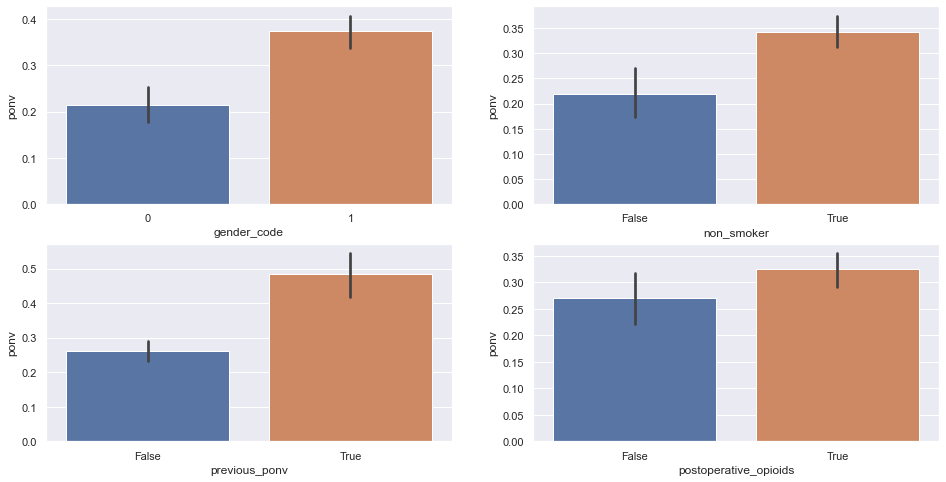

In [7]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.barplot(pp_data['gender_code'], pp_data['ponv'], ax=ax1)

sns.barplot(pp_data['non_smoker'], pp_data['ponv'], ax=ax2)

sns.barplot(pp_data['previous_ponv'], pp_data['ponv'], ax=ax3)

sns.barplot(pp_data['postoperative_opioids'], pp_data['ponv'], ax=ax4)

## Anesthesia technique


In [8]:
tv_x['anesthesia_technique'].value_counts()

4    908
1    461
5    117
2     11
3      9
6      1
Name: anesthesia_technique, dtype: int64

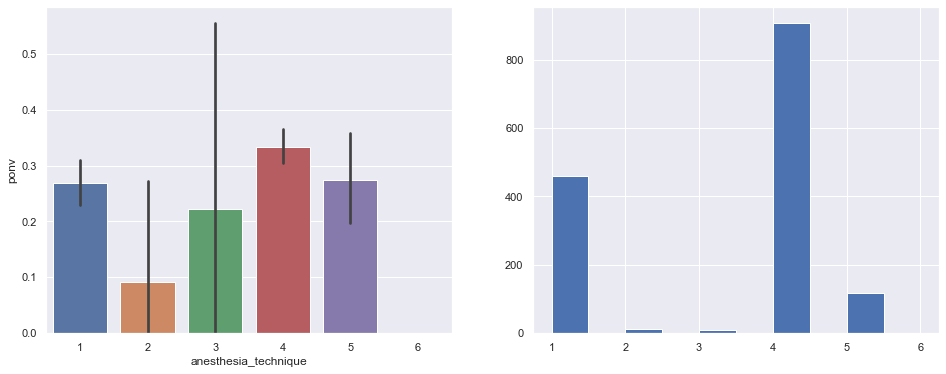

In [9]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(tv_x['anesthesia_technique'], tv_y['ponv'], ax=ax1)
ax2=plt.hist(tv_x['anesthesia_technique'])

Although a key wasn't available to explain what each of the techniques were, I don't believe further analysis is required given the ponv rate for all the techniques seem pretty similar. *I may need to do a hypothesis test to justify?*

## Baseline Random Forest Regressor vs. Apfel

In [10]:
baseline_val_x = val_x[apfel_feat]

In [12]:
baseline_val_x.head()

,gender_code,non_smoker,previous_ponv,postoperative_opioids
364,1,True,True,True
384,0,True,False,True
1354,1,True,False,True
751,0,True,False,True
1396,1,True,False,True


In [13]:
# Baseline RFC model
baseline_x = pp_data.drop('ponv', axis=1)
baseline_y = pp_data['ponv']
baseline_rfc = RandomForestClassifier()
baseline_rfc.fit(baseline_x, baseline_y)
rfc_pred = baseline_rfc.predict(baseline_val_x)

## Baseline PONV positive set in train/val set

In [14]:
sum(tv_y['ponv'])/len(tv_y['ponv'])

0.30590577305905775

In [15]:
baseline_comp = val_x[['patientid', 'apfel']]
baseline_comp

,patientid,apfel
364,379,4
384,400,2
1354,1471,3
751,802,2
1396,1515,3
...,...,...
1097,1194,3
1610,1736,4
717,764,2
710,757,1


In [16]:
baseline_comp['apfel_prob'] = baseline_comp['apfel'].map({0:.1, 1:.2, 2:.4, 3:.6, 4:.8})

<ipython-input-16-399319a8c43e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_comp['apfel_prob'] = baseline_comp['apfel'].map({0:.1, 1:.2, 2:.4, 3:.6, 4:.8})


In [17]:
baseline_comp['baseline_rfc'] = baseline_rfc.predict_proba(baseline_val_x)[:,0]

<ipython-input-17-4912f435a3bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_comp['baseline_rfc'] = baseline_rfc.predict_proba(baseline_val_x)[:,0]


In [18]:
baseline_comp['apfel_pred'] = baseline_comp['apfel_prob'].apply(lambda x: True if x > 0.5 else False)

<ipython-input-18-f84775707a53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_comp['apfel_pred'] = baseline_comp['apfel_prob'].apply(lambda x: True if x > 0.5 else False)


In [19]:
baseline_comp['rfc_pred'] = baseline_rfc.predict(baseline_val_x)

<ipython-input-19-b91c719ec21a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_comp['rfc_pred'] = baseline_rfc.predict(baseline_val_x)


In [20]:
baseline_comp['actual'] = val_y['ponv']

<ipython-input-20-3a33aba96aba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_comp['actual'] = val_y['ponv']


In [21]:
baseline_comp = pd.concat([baseline_comp, baseline_val_x], axis=1)

Text(30.5, 0.5, 'Actual')

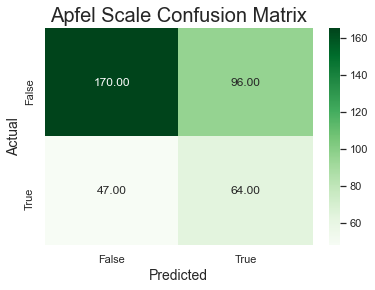

In [22]:
fig = plt.figure()
ax = sns.heatmap(confusion_matrix(baseline_comp['actual'], baseline_comp['apfel_pred']), cmap='Greens', 
            annot=True, fmt='0.2f', robust = True, yticklabels=['False', 'True'],
            xticklabels=['False', 'True'])
plt.title('Apfel Scale Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
#plt.savefig('../ppt/Apfel_cm.png')

Text(30.5, 0.5, 'Actual')

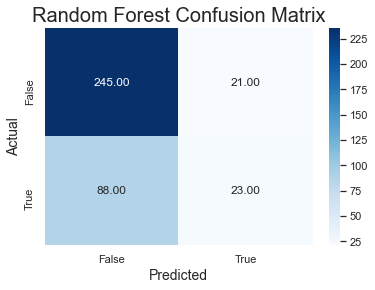

In [23]:
sns.heatmap(confusion_matrix(baseline_comp['actual'], baseline_comp['rfc_pred']), cmap='Blues', 
            annot=True, fmt='0.2f', linecolor='black', robust=True, yticklabels=['False', 'True'],
            xticklabels=['False', 'True'])
plt.title('Random Forest Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
#plt.savefig('../ppt/RFC_cm.png')

# Without Resampling

In [24]:
apfel_tv_x = tv_x[apfel_feat]

In [25]:
#tv_x.to_pickle('../pkl_files/tv_x.pkl')
#tv_y['ponv'].to_pickle('../pkl_files/tv_y.pkl')

# EDA of features by category

## PONV on different surgeries

In [26]:
proc_feat = analysis_df.iloc[:,np.r_[55,58:83]].groupby('ponv').sum().T
proc_feat

ponv,False,True
gastrointestinal,321,135
mastectomy,178,85
thoracic,91,37
nephrectomy,78,38
hysterectomy,71,36
exploratory_laparotomy,71,26
spine_surgery,59,15
cystectomy,42,24
prostatectomy,44,13
hepatectomy,39,14


In [27]:
proc_feat['subtotal_surg'] = proc_feat[True]+proc_feat[False]
proc_feat['ponv_rate'] = proc_feat[True]/proc_feat['subtotal_surg']

In [28]:
surg_ponv_summary = proc_feat[proc_feat['subtotal_surg']>20]
surg_ponv_summary = surg_ponv_summary.sort_values(by='ponv_rate', ascending=False).reset_index()
list(surg_ponv_summary['index'][:19])

['pancreatectomy',
 'hysterectomy_vlp',
 'anexectomy_ovariectomy',
 'cystectomy',
 'extensive_lymphadenectomy',
 'plastic',
 'cytoreduction',
 'hysterectomy',
 'nephrectomy',
 'mastectomy',
 'gastrointestinal',
 'thoracic',
 'exploratory_laparotomy',
 'hepatectomy',
 'prostatectomy',
 'breast_lumpectomy',
 'spine_surgery',
 'head_neck',
 'orthopedic']

<BarContainer object of 18 artists>

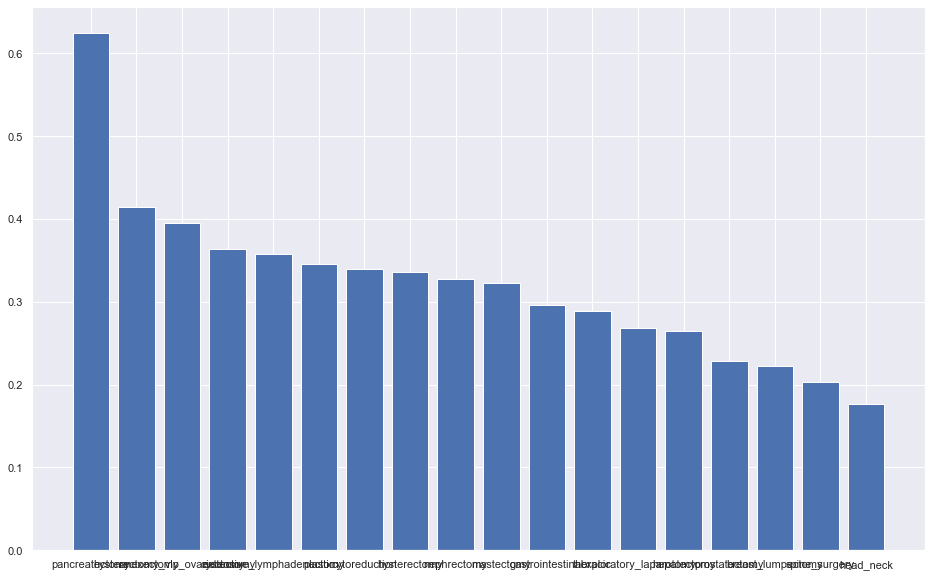

In [29]:
plt.figure(figsize=(16,10))
plt.bar(surg_ponv_summary['index'][:18], surg_ponv_summary['ponv_rate'][:18])

In [30]:
surg_filter = list(surg_ponv_summary['index'][:18])
surg_x = tv_x[surg_filter]
surg_y = tv_y

In [31]:
agg_df_x = pd.concat([apfel_tv_x, surg_x], axis=1)

In [33]:
import PONV_classifier_models as pcm

In [44]:
pcm.evaluate_models([1,2,3], agg_df_x, tv_y['ponv'])

LogisticRegression
Avg. f1 score: 0.4484776523731407
Avg. Roc/Auc score 0.6280801234314327
RandomForestClassifier
Avg. f1 score: 0.42452995343208483
Avg. Roc/Auc score 0.6003067556561205
GaussianNB
Avg. f1 score: 0.4292682127352822
Avg. Roc/Auc score 0.5913676987413052


{1: {2: 0.48178739754273225,
  28: 0.69033021082919,
  44: 0.36905930287044914,
  45: 0.38775430091486346,
  51: 0.5838415910622143,
  60: 0.5125853063941467,
  62: 0.6915622176652697,
  64: 0.48178739754273225,
  71: 0.48178739754273225,
  79: 0.1791067107870904,
  83: 0.39064825788294355,
  92: 0.32472455510526815,
  94: 0.32472455510526815,
  95: 0.44039946420101034,
  101: 0.6414724528630265,
  105: 0.48095816148894854,
  123: 0.48178739754273225,
  129: 0.14612337703350745,
  131: 0.5488070992456965,
  138: 0.41761304499700874,
  158: 0.2735902887400203,
  166: 0.8189955900094033,
  172: 0.6485659276988104,
  182: 0.7346137872953793,
  207: 0.6374320901994434,
  212: 0.3706244885892501,
  221: 0.24353270164367982,
  229: 0.36905930287044914,
  231: 0.46966564872593614,
  236: 0.4017021594170709,
  237: 0.7189795249258999,
  238: 0.5493323789437646,
  239: 0.23888646762862625,
  242: 0.4881280815895992,
  243: 0.34276706663535084,
  253: 0.763069369690657,
  254: 0.5741895286458566

## Anesthetic effect on PONV

In [45]:
tv_x.iloc[:,14:24]

,remifentanil,fentanil_mcg,sufentanil_mcg,continuous_sufentanil,tramadol_pacu,tramadol_dose_pacu,intraoperative_ketamine,ketamine_dose,intraoperative_morphine,intraoperative_morphine_dose
861,False,0.0,50.0,False,False,0.0,False,0.0,False,0.0
1370,False,300.0,0.0,False,False,0.0,False,0.0,False,0.0
946,False,0.0,130.0,False,False,0.0,False,0.0,False,0.0
697,False,0.0,75.0,False,False,0.0,False,0.0,False,0.0
1883,True,250.0,0.0,False,False,0.0,False,0.0,False,0.0
...,...,...,...,...,...,...,...,...,...,...
1394,False,600.0,0.0,False,False,0.0,False,0.0,False,0.0
1345,False,250.0,0.0,False,False,0.0,False,0.0,False,0.0
528,False,350.0,0.0,False,False,0.0,False,0.0,False,0.0
1150,False,0.0,0.0,False,False,0.0,False,0.0,False,0.0


In [46]:
dosage = ['fentanil_mcg', 'sufentanil_mcg', 'tramadol_dose_pacu', 
          'ketamine_dose', 'intraoperative_morphine_dose']
opioid_feat = tv_x[dosage]
opioid_feat['ponv'] = tv_y['ponv']
opioid_feat[['fentanil_mcg', 'sufentanil_mcg']] = opioid_feat[['fentanil_mcg', 'sufentanil_mcg']]/1000

<ipython-input-46-9b05151cbb17>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opioid_feat['ponv'] = tv_y['ponv']
/Users/paulchung/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [47]:
anes_smry = opioid_feat.groupby('ponv', as_index=False).mean()
anes_smry

,ponv,fentanil_mcg,sufentanil_mcg,tramadol_dose_pacu,ketamine_dose,intraoperative_morphine_dose
0,False,0.183606,0.024173,3.154876,2.367591,0.752868
1,True,0.211996,0.018553,4.772234,1.379610,0.639913


### Notable variance in average fentanil and tramadol dosage

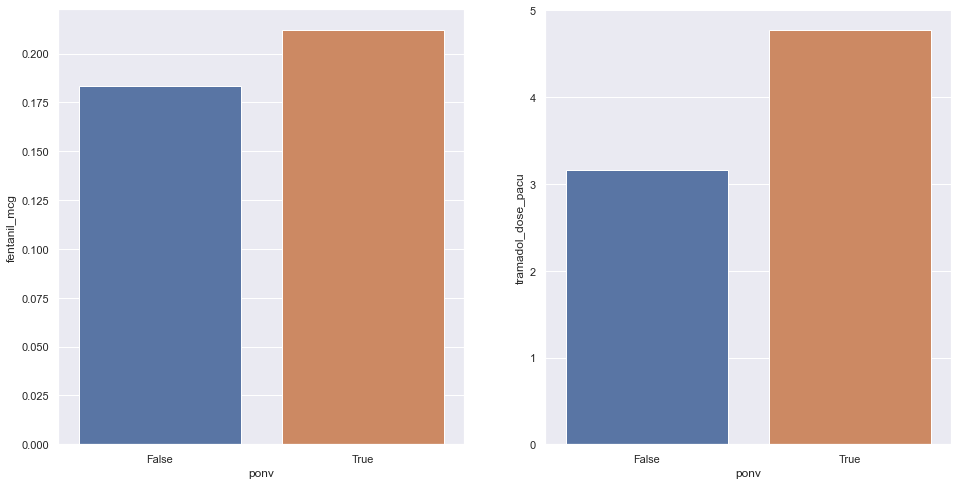

In [48]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.barplot(anes_smry['ponv'], anes_smry['fentanil_mcg'], ax=ax1)
sns.barplot(anes_smry['ponv'], anes_smry['tramadol_dose_pacu'], ax=ax2)

In [50]:
drug_x = opioid_feat.drop('ponv', axis=1)
pcm.evaluate_models([1,2,3], drug_x, tv_y['ponv'])

LogisticRegression
Avg. f1 score: 0.29404265939891766
Avg. Roc/Auc score 0.5346831972078278
RandomForestClassifier
Avg. f1 score: 0.32187453777305686
Avg. Roc/Auc score 0.5193037887486293
GaussianNB
Avg. f1 score: 0.3658874934366005
Avg. Roc/Auc score 0.5254497292143131


{1: {2: 0.40788618018439254,
  28: 0.4923646750462319,
  44: 0.4039346042679774,
  45: 0.4923646750462319,
  51: 0.42331258858610415,
  60: 0.5090901752742151,
  62: 0.5090901752742151,
  64: 0.4756562487468532,
  71: 0.5024003203353411,
  79: 0.45458872650683,
  83: 0.46510692490888556,
  92: 0.42589912128896623,
  94: 0.6254305218170975,
  95: 0.4890204276669696,
  101: 0.4493441936199762,
  105: 0.4598433542390738,
  123: 0.5324633787047769,
  129: 0.5633080284768284,
  131: 0.45458872650683,
  138: 0.4362845024470887,
  158: 0.4756562487468532,
  166: 0.46774170167568907,
  172: 0.4990549207962732,
  182: 0.4923646750462319,
  207: 0.45458872650683,
  212: 0.4493441936199762,
  221: 0.4598433542390738,
  229: 0.531302321588974,
  231: 0.5090901752742151,
  236: 0.4756562487468532,
  237: 0.5024003203353411,
  238: 0.43888997434492005,
  239: 0.4756562487468532,
  242: 0.4565379220411363,
  243: 0.458359187043951,
  253: 0.49204106517578955,
  254: 0.42331258858610415,
  283: 0.4261

In [51]:
agg_df_x = pd.concat([apfel_tv_x, surg_x, drug_x], axis=1)

In [52]:
agg_df_x.columns

Index(['gender_code', 'non_smoker', 'previous_ponv', 'postoperative_opioids',
       'pancreatectomy', 'hysterectomy_vlp', 'anexectomy_ovariectomy',
       'cystectomy', 'extensive_lymphadenectomy', 'plastic', 'cytoreduction',
       'hysterectomy', 'nephrectomy', 'mastectomy', 'gastrointestinal',
       'thoracic', 'exploratory_laparotomy', 'hepatectomy', 'prostatectomy',
       'breast_lumpectomy', 'spine_surgery', 'head_neck', 'fentanil_mcg',
       'sufentanil_mcg', 'tramadol_dose_pacu', 'ketamine_dose',
       'intraoperative_morphine_dose'],
      dtype='object')

In [53]:
pcm.evaluate_models([1,2,3], agg_df_x, tv_y['ponv'])

LogisticRegression
Avg. f1 score: 0.43023132920557133
Avg. Roc/Auc score 0.6294806953194301
RandomForestClassifier
Avg. f1 score: 0.4046343792285933
Avg. Roc/Auc score 0.6009364941874017
GaussianNB
Avg. f1 score: 0.4210517463315264
Avg. Roc/Auc score 0.5924009655925652


{1: {2: 0.41348979134151165,
  28: 0.7042100126411938,
  44: 0.3534603757963222,
  45: 0.41048974393559706,
  51: 0.5297995074149451,
  60: 0.5581790133471585,
  62: 0.7170187035108059,
  64: 0.4889632896724847,
  71: 0.5083007782256451,
  79: 0.17346638849525145,
  83: 0.3786817037097822,
  92: 0.28141475556742174,
  94: 0.408006599436648,
  95: 0.45888893313057405,
  101: 0.6174724673865299,
  105: 0.4612680743277379,
  123: 0.5300229299101746,
  129: 0.16236638975631515,
  131: 0.5333548244482679,
  138: 0.38332809959200714,
  158: 0.28276899875765416,
  166: 0.8153862224125135,
  172: 0.6677628267735141,
  182: 0.7476393049382427,
  207: 0.6217585463458447,
  212: 0.3571026610715847,
  221: 0.23037958071540823,
  229: 0.41360000796692453,
  231: 0.5022389738687887,
  236: 0.40781481993729907,
  237: 0.7422684799491276,
  238: 0.5067295555546911,
  239: 0.2429273529282117,
  242: 0.5028565167923655,
  243: 0.3626091340389575,
  253: 0.7794055516805646,
  254: 0.5174320584302083,
  2

## Quick check on age

In [55]:
#Age appears to have no discernable effect
age_df = pd.concat([tv_x['age'], tv_y['ponv']], axis=1)
age_df

,age,ponv
861,49,False
1370,37,False
946,51,False
697,64,True
1883,47,True
...,...,...
1394,53,False
1345,65,True
528,79,False
1150,59,False


In [56]:
agg_df_x = pd.concat([apfel_tv_x, surg_x, drug_x, age_df['age']], axis=1)

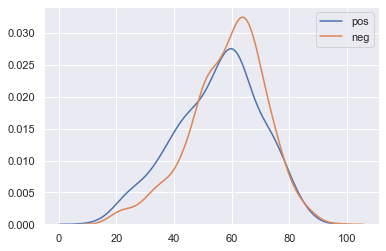

In [57]:
sns.kdeplot(age_df[age_df['ponv'] == True]['age'])
sns.kdeplot(age_df[age_df['ponv'] == False]['age'])
plt.legend(['pos', 'neg'])

# Effect of Chemo

In [58]:
chemo_df = tv_x.iloc[:,8:12]
chemo_df

,previous_chemotherapy,how_many_months_ago_chemotherapy,post_chemotherapy_nausea,post_chemotherapy_vomiting
861,False,0.0,False,False
1370,True,36.0,False,False
946,True,1.0,False,True
697,False,0.0,False,False
1883,True,2.0,True,True
...,...,...,...,...
1394,True,3.0,True,True
1345,False,0.0,False,False
528,True,36.0,False,False
1150,False,0.0,False,False


In [60]:
pcm.evaluate_models([1,2,3], chemo_df, tv_y['ponv'])

LogisticRegression
Avg. f1 score: 0.33274987517786797
Avg. Roc/Auc score 0.5808839478155009
RandomForestClassifier
Avg. f1 score: 0.3003642922697218
Avg. Roc/Auc score 0.5604407977512075
GaussianNB
Avg. f1 score: 0.31015990231462776
Avg. Roc/Auc score 0.5503706712294992


{1: {2: 0.3228286770391704,
  28: 0.348216584101925,
  44: 0.5825433420850707,
  45: 0.4612288440422071,
  51: 0.4612288440422071,
  60: 0.4612288440422071,
  62: 0.565628008934166,
  64: 0.4612288440422071,
  71: 0.352360269246403,
  79: 0.3507000863655333,
  83: 0.4612288440422071,
  92: 0.4612288440422071,
  94: 0.4612288440422071,
  95: 0.4612288440422071,
  101: 0.3515297290201595,
  105: 0.352360269246403,
  123: 0.4612288440422071,
  129: 0.3515297290201595,
  131: 0.5781090431364874,
  138: 0.4612288440422071,
  158: 0.4612288440422071,
  166: 0.4612288440422071,
  172: 0.6030060385782638,
  182: 0.4612288440422071,
  207: 0.4612288440422071,
  212: 0.4612288440422071,
  221: 0.3515297290201595,
  229: 0.4612288440422071,
  231: 0.5816575253678337,
  236: 0.4612288440422071,
  237: 0.4612288440422071,
  238: 0.4612288440422071,
  239: 0.4612288440422071,
  242: 0.34904350990009503,
  243: 0.4612288440422071,
  253: 0.2607618126158151,
  254: 0.5816575253678337,
  283: 0.4612288

In [62]:
agg_df_x = pd.concat([apfel_tv_x, surg_x, drug_x, chemo_df], axis=1)
pcm.evaluate_models([1,2,3], agg_df_x, tv_y['ponv'])

LogisticRegression
Avg. f1 score: 0.44721658657339997
Avg. Roc/Auc score 0.6351765993203639
RandomForestClassifier
Avg. f1 score: 0.4196532823751673
Avg. Roc/Auc score 0.6157543835330975
GaussianNB
Avg. f1 score: 0.4352785934491034
Avg. Roc/Auc score 0.6054488119836836


{1: {2: 0.31924025411761014,
  28: 0.6320064717373027,
  44: 0.4123692998497595,
  45: 0.4174499540255619,
  51: 0.5308560811469232,
  60: 0.5714032621853048,
  62: 0.7352554109907479,
  64: 0.4884024936237098,
  71: 0.4384314765578914,
  79: 0.13151182731102606,
  83: 0.3777613834279683,
  92: 0.28889006930349537,
  94: 0.41258731426706546,
  95: 0.4723811013458775,
  101: 0.5461531621200951,
  105: 0.39740728343899073,
  123: 0.5266036284850317,
  129: 0.13167558067202112,
  131: 0.5759842966263026,
  138: 0.3892773788513617,
  158: 0.30341643117017936,
  166: 0.8000660227222136,
  172: 0.7359411821847036,
  182: 0.7271662461964844,
  207: 0.6054890848926463,
  212: 0.34022406451157683,
  221: 0.18856835308351425,
  229: 0.3985410690554148,
  231: 0.5578081672656301,
  236: 0.4236958625173593,
  237: 0.721237945786142,
  238: 0.5033037204063033,
  239: 0.24457701229654613,
  242: 0.4378479702881944,
  243: 0.37249691594466405,
  253: 0.5842529408299957,
  254: 0.5763124147411666,
  2

## Additional Data

In [63]:
surgery_times_df = pd.read_csv('../raw_data/surgery_time.csv')

In [64]:
surgery_times_df

,Specialties,Number of the surgeries n (%),Duration of the anesthesia,Duration of the surgery,Operating room time
0,Orthopedics,"1,385 (16.6)",207.52±104.96,151.95±92.45,228.18±110.30
1,General and Gastrointestinal Surgery,"1,324 (15.9)",200.01±110.38,150.95±98.27,218.01±113.73
2,Gynecology/ Mastology,"1,116 (13.4)",109.95± 89.34,79.32±79.43,128.46±92.46
3,Urology,959 (11.5),135.44± 86.85,94.00±77.30,153.99±90.24
4,Plastic Surgery,779 (9.3),205.73±106.92,157.72±97.44,225.75±111.74
5,Otolaryngology,719 (8.6),176.54±96.48,129.23±86.64,194.88±98.54
6,Ophthalmology,669 (8.0),153.54±94.85,111.38±86.19,172.02±97.26
7,Neurosurgery,447 (5.4),199.27±104.05,135.06±92.12,218.45±105.66
8,Vascular Surgery,314 (3.8),193.53±114.88,144.78±102.34,215.36±117.57
9,Head and Neck,280 (3.4),257.63±145.36,202.45±133.31,279.19±147.67


In [65]:
surgery_times_df = pd.concat([surgery_times_df['Specialties'],surgery_times_df['Duration of the anesthesia'].str.split('±', expand=True)], axis=1)

In [66]:
surgery_times_df.rename({'Specialties':'surg_time_key', 0:'avg_time',1:'std_time'}, axis=1, inplace=True)

In [67]:
surgery_times_df[['avg_time', 'std_time']] = surgery_times_df[['avg_time','std_time']].astype(float)

In [68]:
analysis_df['surgery_group'].unique()

array(['Gastrointenstinal Surgery', 'Other', 'Exploratory Laparotomy',
       'Ortopedic Surgery', 'Urologic Surgery', 'Gynaecological Surgery',
       'Head and Neck Surgery', 'Breast surgery', 'Thoracic Surgery',
       'Lymphadenectomy', 'Plastic Surgery'], dtype=object)

In [69]:
analysis_df.columns

Index(['patientid', 'age', 'apfel', 'previous_ponv', 'postoperative_opioids',
       'non_smoker', 'surgery_group', 'chronic_opioid_user',
       'previous_chemotherapy', 'how_many_months_ago_chemotherapy',
       'post_chemotherapy_nausea', 'post_chemotherapy_vomiting',
       'anesthesia_technique', 'intraoperative_opioid', 'remifentanil',
       'fentanil_mcg', 'sufentanil_mcg', 'continuous_sufentanil',
       'tramadol_pacu', 'tramadol_dose_pacu', 'intraoperative_ketamine',
       'ketamine_dose', 'intraoperative_morphine',
       'intraoperative_morphine_dose', 'ondansetron_intraoperative',
       'intraoperative_ondansetron_dose', 'intraoperative_dexamethasone',
       'dexamethasone_dose', 'intraoperative_dimenidrate',
       'intraoperative_dimenidrate_dose', 'intraoperative_metoclopramide',
       'metoclopramide_dose', 'intraoperative_droperidol', 'droperidol_dose',
       'nausea_6h', 'vomiting_6h', 'rescue_antiemetic_6h',
       'rescue_antiemetic_6h_which',
       'postope

## Not seeing a significant connection between surgery time; problem is also in data. Standard deviations are huge.

# Emetogenics

Last minute I discovered that these features may potentially be causing data leakage as the coefficients indicated the emetogenic medicine was ***increasing*** the probability of PONV, which didn't make intuitive sense. I figured the doctors were giving patients higher doses based on their Apfel risk score so I ended up omitting the features individually. I did, however, aggregate the total amounts of IV drugs provided (both opioid and emetogenics) as an engineered feature to account for headache side effects commonly associated with emetogenics. 

In [72]:
tv_x.iloc[:,46:52]

,regular_ondansetron,regular_dexamethasone,regular_dimenidrate,regular_bromopride,regular_metoclopramide,regular_droperidol
861,False,False,False,False,True,False
1370,False,False,False,False,True,False
946,False,False,False,False,False,False
697,False,False,False,False,False,False
1883,True,False,False,False,False,False
...,...,...,...,...,...,...
1394,False,False,False,False,False,False
1345,True,False,False,False,True,False
528,False,False,False,False,False,False
1150,False,False,False,False,False,False


In [73]:
emetogenic_df = pd.concat([tv_x.iloc[:,25:35],tv_y],axis=1)

In [74]:
emetogenic_df.describe(include='all')

,intraoperative_ondansetron_dose,intraoperative_dexamethasone,dexamethasone_dose,intraoperative_dimenidrate,intraoperative_dimenidrate_dose,intraoperative_metoclopramide,metoclopramide_dose,intraoperative_droperidol,droperidol_dose,nausea_6h,ponv,vomiting24h
count,1507.000000,1507,1507.000000,1507,1507.000000,1507,1507.000000,1507,1507.000000,1507,1507,1503
unique,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,2,2
top,NaN,True,NaN,False,NaN,False,NaN,False,NaN,False,False,False
freq,NaN,843,NaN,1494,NaN,1469,NaN,1495,NaN,1291,1046,1249
mean,6.155275,NaN,3.818845,NaN,0.285335,NaN,0.252157,NaN,0.036828,NaN,NaN,NaN
std,3.232437,NaN,3.823422,NaN,3.216131,NaN,1.568316,NaN,0.439826,NaN,NaN,NaN
min,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,4.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
50%,8.000000,NaN,4.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
75%,8.000000,NaN,8.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN


In [75]:
emet_dose_list = ['intraoperative_ondansetron_dose', 'dexamethasone_dose', 'intraoperative_dimenidrate_dose',
                   'metoclopramide_dose', 'droperidol_dose']
emet_dose_df = tv_x[emet_dose_list]

In [76]:
emet_dose_df.describe()

,intraoperative_ondansetron_dose,dexamethasone_dose,intraoperative_dimenidrate_dose,metoclopramide_dose,droperidol_dose
count,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000
mean,6.155275,3.818845,0.285335,0.252157,0.036828
std,3.232437,3.823422,3.216131,1.568316,0.439826
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,4.000000,0.000000,0.000000,0.000000
75%,8.000000,8.000000,0.000000,0.000000,0.000000
max,8.000000,10.000000,50.000000,10.000000,6.250000


In [78]:
pcm.evaluate_models([1,2,3], emet_dose_df, tv_y['ponv'])

LogisticRegression
Avg. f1 score: 0.17930358244055697
Avg. Roc/Auc score 0.5462519842672812
RandomForestClassifier
Avg. f1 score: 0.23500654472089186
Avg. Roc/Auc score 0.5375726841360754
GaussianNB
Avg. f1 score: 0.19962540955402266
Avg. Roc/Auc score 0.5429475424516909


{1: {2: 0.36715064030392003,
  28: 0.4975079084580056,
  44: 0.4975079084580056,
  45: 0.43630961467541624,
  51: 0.4975079084580056,
  60: 0.4975079084580056,
  62: 0.4975079084580056,
  64: 0.4110027140524197,
  71: 0.43630961467541624,
  79: 0.4975079084580056,
  83: 0.46678380988642987,
  92: 0.46678380988642987,
  94: 0.4975079084580056,
  95: 0.3815642526156542,
  101: 0.43630961467541624,
  105: 0.43630961467541624,
  123: 0.46678380988642987,
  129: 0.46678380988642987,
  131: 0.45150124524721125,
  138: 0.43630961467541624,
  158: 0.4975079084580056,
  166: 0.4975079084580056,
  172: 0.45150124524721125,
  182: 0.4212365810535527,
  207: 0.43630961467541624,
  212: 0.45150124524721125,
  221: 0.4975079084580056,
  229: 0.4212365810535527,
  231: 0.4975079084580056,
  236: 0.44109247786466643,
  237: 0.4975079084580056,
  238: 0.4110027140524197,
  239: 0.4110027140524197,
  242: 0.4110027140524197,
  243: 0.4975079084580056,
  253: 0.43630961467541624,
  254: 0.466783809886429

In [79]:
agg_df_x = pd.concat([apfel_tv_x, surg_x, drug_x, chemo_df, age_df['age'], emet_dose_df], axis=1)
agg_df_x

,gender_code,non_smoker,previous_ponv,postoperative_opioids,pancreatectomy,hysterectomy_vlp,anexectomy_ovariectomy,cystectomy,extensive_lymphadenectomy,plastic,...,previous_chemotherapy,how_many_months_ago_chemotherapy,post_chemotherapy_nausea,post_chemotherapy_vomiting,age,intraoperative_ondansetron_dose,dexamethasone_dose,intraoperative_dimenidrate_dose,metoclopramide_dose,droperidol_dose
861,1,True,False,False,0,0,0,0,0,0,...,False,0.0,False,False,49,8.0,0.0,0.0,0.0,0.0
1370,1,True,False,True,0,0,0,0,0,0,...,True,36.0,False,False,37,8.0,4.0,0.0,0.0,0.0
946,1,True,False,True,0,0,0,0,0,0,...,True,1.0,False,True,51,0.0,10.0,0.0,0.0,0.0
697,1,True,False,False,0,0,0,0,0,0,...,False,0.0,False,False,64,4.0,4.0,0.0,0.0,0.0
1883,1,True,False,True,0,0,0,0,0,0,...,True,2.0,True,True,47,8.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,0,False,False,True,0,0,0,0,0,0,...,True,3.0,True,True,53,8.0,0.0,0.0,0.0,0.0
1345,0,True,True,True,0,0,0,0,0,0,...,False,0.0,False,False,65,8.0,0.0,0.0,0.0,0.0
528,0,True,True,True,0,0,0,0,0,0,...,True,36.0,False,False,79,8.0,0.0,0.0,0.0,0.0
1150,1,True,False,False,0,0,0,0,0,0,...,False,0.0,False,False,59,8.0,8.0,0.0,0.0,0.0


## Smokers

In [83]:
quitters = pd.concat([tv_x['when_stopped_smoking'], tv_y['ponv']], axis=1)

In [84]:
quitters

,when_stopped_smoking,ponv
861,1.0,False
1370,1.0,False
946,1.0,False
697,1.0,True
1883,1.0,True
...,...,...
1394,4.0,False
1345,2.0,True
528,1.0,False
1150,1.0,False


In [86]:
tv_x['when_stopped_smoking'].value_counts()

1.000000    810
2.000000    465
3.000000     78
5.000000     74
1.669796     55
4.000000     25
Name: when_stopped_smoking, dtype: int64

In [90]:
tv_x['packets_years'].value_counts().head()

0.0     915
15.0    190
20.0     52
30.0     47
40.0     44
Name: packets_years, dtype: int64

# Feature Engineering

In [91]:
agg_df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1507 entries, 861 to 1290
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gender_code                       1507 non-null   int64  
 1   non_smoker                        1507 non-null   bool   
 2   previous_ponv                     1507 non-null   bool   
 3   postoperative_opioids             1507 non-null   bool   
 4   pancreatectomy                    1507 non-null   int64  
 5   hysterectomy_vlp                  1507 non-null   int64  
 6   anexectomy_ovariectomy            1507 non-null   int64  
 7   cystectomy                        1507 non-null   int64  
 8   extensive_lymphadenectomy         1507 non-null   int64  
 9   plastic                           1507 non-null   int64  
 10  cytoreduction                     1507 non-null   int64  
 11  hysterectomy                      1507 non-null   int64  
 12  neph

In [92]:
agg_df_x.iloc[:,22:24].describe()

,fentanil_mcg,sufentanil_mcg
count,1507.000000,1507.000000
mean,0.192291,0.022454
std,0.261714,0.048586
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.350000,0.035000
max,1.600000,0.600000


In [93]:
agg_df_x['tot_drugs']= agg_df_x[['tramadol_dose_pacu','ketamine_dose', 
                                'intraoperative_morphine_dose']].sum(axis=1) +\
                                emet_dose_df.sum(axis=1)+\
                                agg_df_x[['fentanil_mcg', 'sufentanil_mcg']].sum(axis=1)*1000

In [94]:
agg_df_x['tot_drugs']

861      58.0
1370    312.0
946     140.0
697      83.0
1883    258.0
        ...  
1394    608.0
1345    258.0
528     358.0
1150     16.0
1290    266.0
Name: tot_drugs, Length: 1507, dtype: float64

In [135]:
#agg_df_x.to_pickle('../pkl_files/agg_df_x.pkl')
#tv_y.to_pickle('../pkl_files/tv_y.pkl')

In [95]:
agg_df_x = pd.read_pickle('../pkl_files/agg_df_x.pkl')
tv_y=pd.read_pickle('../pkl_files/tv_y.pkl')

In [96]:
agg_df_x['tot_drugs'].value_counts()

0.0       62
258.0     51
508.0     47
8.0       41
58.0      37
          ..
556.0      1
67.0       1
331.0      1
1600.0     1
669.0      1
Name: tot_drugs, Length: 352, dtype: int64

In [97]:
import log_reg_tuning as lrt

In [98]:
agg_df_x.columns

Index(['gender_code', 'non_smoker', 'previous_ponv', 'postoperative_opioids',
       'pancreatectomy', 'hysterectomy_vlp', 'anexectomy_ovariectomy',
       'cystectomy', 'extensive_lymphadenectomy', 'plastic', 'cytoreduction',
       'hysterectomy', 'nephrectomy', 'mastectomy', 'thoracic',
       'exploratory_laparotomy', 'hepatectomy', 'prostatectomy',
       'breast_lumpectomy', 'spine_surgery', 'head_neck', 'orthopedic',
       'fentanil_mcg', 'sufentanil_mcg', 'tramadol_dose_pacu', 'ketamine_dose',
       'intraoperative_morphine_dose', 'previous_chemotherapy',
       'how_many_months_ago_chemotherapy', 'post_chemotherapy_nausea',
       'post_chemotherapy_vomiting', 'age', 'intraoperative_ondansetron_dose',
       'dexamethasone_dose', 'intraoperative_dimenidrate_dose',
       'metoclopramide_dose', 'droperidol_dose', 'tot_drugs'],
      dtype='object')

In [99]:
lrt_phaseI = lrt.ponv_log_reg(agg_df_x, tv_y)

Avg. f1 score: 0.5037423098724992
Avg. Roc/Auc score 0.6756247437422276


In [100]:
dict(zip(list(agg_df_x),lrt_phaseI.coef_[0]))

{'gender_code': 0.2562206236206507,
 'non_smoker': 0.2735920706097462,
 'previous_ponv': 0.34067333284828727,
 'postoperative_opioids': 0.06254689720610887,
 'pancreatectomy': 0.031012594967179598,
 'hysterectomy_vlp': -0.03172746650348287,
 'anexectomy_ovariectomy': 0.004889106489194983,
 'cystectomy': 0.11731703869144985,
 'extensive_lymphadenectomy': -0.01076304305787295,
 'plastic': -0.10853645634628262,
 'cytoreduction': -0.07233489223723452,
 'hysterectomy': -0.045827704656985685,
 'nephrectomy': 0.0310315001968055,
 'mastectomy': -0.12454406145708902,
 'thoracic': -0.026381277047468153,
 'exploratory_laparotomy': -0.09667089673144685,
 'hepatectomy': -0.13290759646128503,
 'prostatectomy': -0.09564128736299313,
 'breast_lumpectomy': -0.09284181835337575,
 'spine_surgery': -0.06836376192217676,
 'head_neck': -0.10999869968692629,
 'orthopedic': -0.27885360101293194,
 'fentanil_mcg': 0.016757207031488423,
 'sufentanil_mcg': -0.1911121976116874,
 'tramadol_dose_pacu': -0.0002639517

# Testing Model in STLit

In [101]:
import pandas as pd
import pickle

def load_model(input_dict):
    input_x = pd.DataFrame(input_dict, index=[0])
    my_model = pickle.load(open("lr_pickled_model.p","rb"))
    scaler = pickle.load(open("ponv_scaler.p","rb"))
    sc_x = scaler.transform(input_x)
    prediction = my_model.predict_proba(sc_x)
    return prediction

In [102]:
input_dict = {"Gender":1,
              "Non_Smoker":0,
              "previous_ponv":0,
              "postoperative_opioids":1,
              'pancreatectomy':0,
              'hysterectomy_vlp':0,
              'anexectomy_ovariectomy':0,
              'cystectomy':0,
              'extensive_lymphadenectomy':0,
              'plastic':0,
              'cytoreduction':0,
              'hysterectomy':0,
              'nephrectomy':0,
              'mastectomy':0,
              'thoracic':0,
              'exploratory_laparotomy':0,
              'hepatectomy':0,
              'prostatectomy':1,
              'breast_lumpectomy':0,
              'spine_surgery':0,
              'head_neck':0,
              'orthopedic':0,
              'fentanil_mcg':50,
              'sufentanil_mcg':0,
              'tramadol_dose_pacu':0,
              'ketamine_dose':0,
              'intraoperative_morphine_dose':0,
              'previous_chemotherapy':0,
              'how_many_months_ago_chemotherapy':0,
              'post_chemotherapy_nausea':0,
              'post_chemotherapy_vomiting':0,
              }